<a href="https://colab.research.google.com/github/junyi2022/musa-650-remote-sensing/blob/main/assignments/HW2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MUSA 650 Homework 2: Supervised Land Use Classification with Google Earth Engine

In this assignment, you will use Google Earth Engine via Python to implement multi-class land cover classification. You will hand-label Landsat 8 satellite images, which you will then use to train a random forest model. Along the way, you will consider practical remote sensing issues like cloud cover, class imbalances, and feature selection.

**Disclaimer:** I consulted the following AI tool to revise code and answer questions for this project.

- DeepSeek. (n.d.). DeepSeek artificial intelligence system. Retrieved from https://www.deepseek.com

**Note:** The output interactive geemap cannot be visualized on GitHub because the 'state' key is missing from 'metadata.widgets'. Although the notebook can be used in Colab, this project decides to use rasterio for its compatibility with GitHub.

## 1. Setup

`geemap` has many [tutorials](https://geemap.org/tutorials/#geemap-tutorials) available. This notebook specificlly referenced the [#32 Machine Learning with Earth Engine - Supervised Classification](https://geemap.org/notebooks/32_supervised_classification/) and the video is available [here](https://www.youtube.com/watch?v=qWaEfgWi21o)

In [1]:
# Import required libraries
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score

# Show all columns
pd.set_option('display.max_columns', None)

In [2]:
class4_palette = ['#DF6149', '#FEDC7B', '#9bcae8', '#6bbf99']

Google Earth Engine requires authentication before usage. Instruction can be found [here](https://developers.google.com/earth-engine/guides/auth). The project is a google cloud project set up in the google cloud account. There is also a notebook autheticator [here](https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jHMQOVzUM-B-pUwoeKSCPjAqmuPK90lbh-Z2xFjR55o&tc=n8BD6km8I2vhYIau8ww5Hrztwrd5Wulp0qdijy5YqII&cc=Yusop5Cp9Vxq3z_wUl9rzbY_q2YP5o1JUMM4lyLIvJs).

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-musa-remote-sensing')

Create a geemap map.

In [6]:
Map = geemap.Map()

## 2. Data Collection and Feature Engineering

### 2.1 Collecting and Labeling Training Data

#### 2.1.1 Collecting Data

The region of interest (ROI) of this notebook is Chicago's suburb. We have defined a rectangle area that will be the area of focus. We first start from adding data to the map. The data used is the Collection 2 for Landsat data in 2023. We filter for images with minimal cloud cover.  

The band info is showed in the form below:

**Landsat 8 (OLI & TIRS) Band Designations**

| Band    | Name                          | Wavelength (µm) | Spatial Resolution (m) | Common Applications |
|---------|-------------------------------|-----------------|------------------------|---------------------|
| **SR_B1** | Coastal/Aerosol               | 0.433–0.453     | 30                     | Coastal water mapping, aerosol studies |
| **SR_B2** | Blue                          | 0.450–0.515     | 30                     | Water body penetration, soil/vegetation discrimination |
| **SR_B3** | Green                         | 0.525–0.600     | 30                     | Healthy vegetation detection, urban areas |
| **SR_B4** | Red                           | 0.630–0.680     | 30                     | Chlorophyll absorption (vegetation health) |
| **SR_B5** | Near-Infrared (NIR)           | 0.845–0.885     | 30                     | Biomass content, water body delineation |
| **SR_B6** | Shortwave Infrared 1 (SWIR 1) | 1.560–1.660     | 30                     | Moisture content, snow/cloud discrimination |
| **SR_B7** | Shortwave Infrared 2 (SWIR 2) | 2.100–2.300     | 30                     | Soil/rock differentiation, vegetation stress |

**Thermal Bands (TIRS)**

| Band     | Name                          | Wavelength (µm) | Spatial Resolution (m) | Common Applications |
|----------|-------------------------------|-----------------|------------------------|---------------------|
| **ST_B10** | Thermal Infrared 1 (TIRS 1)   | 10.60–11.19    | 100 (resampled to 30)  | Surface temperature, urban heat islands |
| **ST_B11** | Thermal Infrared 2 (TIRS 2)   | 11.50–12.51    | 100 (resampled to 30)  | Surface temperature, volcanic activity |

First define the region of interest of Chicago.

In [4]:
chicago_region = ee.Geometry.Rectangle([-88.25, 41.39, -87.8, 41.81])

Then get the landsat image.

In [28]:
# Chicago point
point = ee.Geometry.Point([-87.7719, 41.8799])

# Define scaling function for Landsat Collection 2
def scale_landsat(image):
    # Apply the proper scaling factors for Collection 2
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    return optical_bands.set('system:time_start', image.get('system:time_start'))

image = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(point)
    .filterDate("2023-01-01", "2023-12-31")
    .sort("CLOUD_COVER")
    .first()
    .select("SR_B[1-7]")
    .clip(chicago_region)
)

# Apply scaling to surface reflectance bands
image = scale_landsat(image)

# print(image.getInfo())

Check image properties.

In [6]:
ee.Date(image.get("system:time_start")).format("YYYY-MM-dd").getInfo()

'2023-08-31'

#### 2.1.2 Labeling Data

There are multiple ways to label the data. This notebook use national landcover database (nlcd) layer as a base to generate training points. The values of the points will be reclassified into **0 for urban, 1 for agriculture, 2 for water, and 3 for vegetation**. These 4 categories will be used for the remote sensing model.

First, we want to get the original nlcd data, but it has way more categories than we need.

In [7]:
nlcd = ee.Image("USGS/NLCD/NLCD2016").select("landcover").clip(chicago_region)

In [8]:
print(nlcd.get("landcover_class_values").getInfo())

[11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95]


In this way, we are going to reclassify nlcd data into the 4 categories that we proposed. **0 for urban, 1 for agriculture, 2 for water, and 3 for vegetation**.

In [9]:
# reclassification rules
reclass_rules = {
    # Original NLCD values : New class
    21: 0, 22: 0, 23: 0, 24: 0,  # Urban (Developed)
    31: 1, 52: 1, 71: 3, 81: 3, 82: 3,  # Agriculture (Barren/Shrub/Grasslands/Crops)
    11: 2, 90: 2, 95: 2,  # Water (Water/Wetlands)
    41: 3, 42: 3, 43: 3  # Vegetation (Forests)
}

# Prepare the remapping inputs
from_values = list(reclass_rules.keys())
to_values = list(reclass_rules.values())

# Reclassify the NLCD image
nlcd_reclassified = nlcd.remap(
    from_values,
    to_values,
    defaultValue=-1  # Default value for any pixels not in the mapping
).rename('class')


Export the reclassified nlcd data for future reference.

In [ ]:
# Export image for labeling processing
export_task = ee.batch.Export.image.toDrive(
    image=nlcd_reclassified,
    description="nlcdReclass_export",
    folder="GEE_Exports",
    fileNamePrefix="nlcd_Reclass",
    scale=30,
    region=chicago_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'nlcdReclass_export', 'priority': 100, 'creation_timestamp_ms': 1744836193438, 'update_timestamp_ms': 1744836193438, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'JHGPTWVUC76BTFALD37ZPGBL', 'name': 'projects/ee-musa-remote-sensing/operations/JHGPTWVUC76BTFALD37ZPGBL'}


Generate 500 training points for each landcover category. Here we specifically want a balanced sample so we generate each category separately. The `numPixels` in `sample()` doesn't guarantee the exact count you request - it depends on available valid pixels. In this way, the target count is different for different categories in order to maintain a balanced selection.

In [10]:
# Define target counts per class
target_counts = {
    0: 60,
    1: 4000,
    2: 400,
    3: 100
}

samples = []

for class_val, count in target_counts.items():
    # Sample directly from classified pixels
    class_sample = nlcd_reclassified.updateMask(nlcd_reclassified.eq(class_val)) \
        .sample(
            region=chicago_region,
            scale=30,
            numPixels=count,
            seed=3,
            geometries=True
        )
    samples.append(class_sample.map(lambda f: f.set('class', class_val)))

# Combine all samples
points = ee.FeatureCollection(samples).flatten()

# Verify distribution
print("Class distribution:", points.aggregate_histogram('class').getInfo())

Class distribution: {'0': 32, '1': 34, '2': 34, '3': 32}


Export the training samples

In [ ]:
# Export the full dataset to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=points,
    description='trainning_points_export',
    folder='GEE_Exports',
    fileFormat='GeoJSON'
)

# Start the export
export_task.start()

# Check task status (run this later)
print(export_task.status())

{'state': 'READY', 'description': 'trainning_points_export', 'priority': 100, 'creation_timestamp_ms': 1744838253106, 'update_timestamp_ms': 1744838253106, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'AN4VSFVPU34XQXZVRTTIBXJS', 'name': 'projects/ee-musa-remote-sensing/operations/AN4VSFVPU34XQXZVRTTIBXJS'}


### 2.2 Feature Engineering.

For possible use in the model, calculate and add the following spectral indices:

- **NDVI** (Normalized Difference Vegetation Index)
- **NDBI** (Normalized Difference Built-up Index)
- **MNDWI** (Modified Normalized Difference Water Index)


In [29]:
def add_spectral_indices(img):
    # NDVI - Vegetation index
    ndvi = img.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # NDBI - Built-up index
    ndbi = img.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

    # MNDWI - Water index
    mndwi = img.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

    # Add all indices to the image
    return img.addBands(ndvi).addBands(ndbi).addBands(mndwi)

# Apply to your Landsat image
image = add_spectral_indices(image)

Additionally, add elevation and slope data from a DEM. Normalize all image bands to a 0 to 1 scale for consistent model input.

In [30]:
# Get DEM data
dem = ee.Image("CGIAR/SRTM90_V4").clip(chicago_region)

# Calculate slope (in degrees)
slope = ee.Terrain.slope(dem)

# Resample to 0 to 1
dem = dem.resample('bilinear').reproject(image.projection())
slope = slope.resample('bilinear').reproject(image.projection())

image = image.addBands(dem).addBands(slope)

[Kernel filters](https://google-earth-engine.com/Advanced-Image-Processing/Neighborhood-based-Image-Transformation/) can enhance local spatial patterns like:

- **Edges** between land cover types (great for urban vs. vegetation boundaries)

- **Smoothing** to reduce noise and improve generalization

In [31]:
def add_kernel_filters(img):
    # Edge detection kernels
    sobel_h = ee.Kernel.fixed(3, 3, [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_v = ee.Kernel.fixed(3, 3, [[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    laplacian = ee.Kernel.fixed(3, 3, [[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # Smoothing kernels
    mean_kernel = ee.Kernel.square(3, 'pixels')
    gaussian_kernel = ee.Kernel.gaussian(radius=3, sigma=1, units='pixels')

    # Optimal bands for filtering
    bands_to_filter = ['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6']  # Green, Red, NIR, SWIR1

    for band in bands_to_filter:
        # Edge detection
        img = img.addBands(
            img.select(band).convolve(sobel_h).rename(f'{band}_sobel_h'))
        img = img.addBands(
            img.select(band).convolve(sobel_v).rename(f'{band}_sobel_v'))
        img = img.addBands(
            img.select(band).convolve(laplacian).rename(f'{band}_laplacian'))

        # Smoothing
        img = img.addBands(
            img.select(band).convolve(mean_kernel).rename(f'{band}_mean'))
        img = img.addBands(
            img.select(band).convolve(gaussian_kernel).rename(f'{band}_gauss'))

    return img

# Apply to your image
image = add_kernel_filters(image)

The bands of landsat image need to be in the same data type. For here we use flost32.

In [32]:
# Export image for labeling processing

image = image.toFloat()

export_task = ee.batch.Export.image.toDrive(
    image=image,
    description="landsat_extraLayer",
    folder="GEE_Exports",
    fileNamePrefix="landsat_extraLayer",
    scale=30,
    region=chicago_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'landsat_extraLayer', 'priority': 100, 'creation_timestamp_ms': 1745026617036, 'update_timestamp_ms': 1745026617036, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'XFTVQERCCNDJW4AIRYCY74WX', 'name': 'projects/ee-musa-remote-sensing/operations/XFTVQERCCNDJW4AIRYCY74WX'}


In [ ]:
export_task.status()

{'state': 'COMPLETED',
 'description': 'landsat_extraLayer',
 'priority': 100,
 'creation_timestamp_ms': 1744841305559,
 'update_timestamp_ms': 1744841548326,
 'start_timestamp_ms': 1744841311511,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/16ypKnn_a5G9Ig5OP9Tga0VOX8z4eHY8J'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 93.67378997802734,
 'id': 'EHX4ISGCSWT343KHY57UVYXX',
 'name': 'projects/ee-musa-remote-sensing/operations/EHX4ISGCSWT343KHY57UVYXX'}

Plot all the statistics.

In [33]:
def get_complete_image_stats(image, region, scale=30):
    """
    Get comprehensive statistics for all bands in an image, including calculated min/max

    Args:
        image: ee.Image to analyze
        region: ee.Geometry for the area to analyze
        scale: resolution in meters

    Returns:
        pandas.DataFrame with complete band statistics
    """
    # Get basic band info
    image_info = image.getInfo()

    # Prepare to collect statistics
    band_stats_list = []

    # Get all band names
    band_names = [band['id'] for band in image_info['bands']]

    # Calculate statistics for all bands at once (more efficient)
    stats = image.reduceRegion(
        reducer=ee.Reducer.minMax().combine(
            reducer2=ee.Reducer.mean(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        geometry=region,
        scale=scale,
        bestEffort=True,
        maxPixels=1e9
    ).getInfo()

    # Process each band
    for band in image_info['bands']:
        band_id = band['id']

        # Get calculated statistics
        band_min = stats.get(f'{band_id}_min')
        band_max = stats.get(f'{band_id}_max')
        band_mean = stats.get(f'{band_id}_mean')
        band_std = stats.get(f'{band_id}_stdDev')

        # Create band entry
        band_entry = {
            'band_id': band_id,
            'precision': band['data_type']['precision'],
            'min_value': band_min,
            'max_value': band_max,
            'mean_value': band_mean,
            'std_dev': band_std
        }

        band_stats_list.append(band_entry)

    return pd.DataFrame(band_stats_list)

# Usage example:
df_complete_stats = get_complete_image_stats(image, chicago_region, scale=90)
df_complete_stats

band_id precision  min_value   max_value  mean_value    std_dev
0             SR_B1     float  -0.120140    0.627558    0.037158   0.035574
1             SR_B2     float  -0.094290    0.682943    0.044331   0.041197
2             SR_B3     float  -0.007693    0.754332    0.071174   0.048243
3             SR_B4     float  -0.025843    0.801853    0.067651   0.058143
4             SR_B5     float  -0.000048    0.837218    0.301015   0.081213
5             SR_B6     float   0.001383    0.731727    0.185113   0.060134
6             SR_B7     float   0.000970    0.737888    0.109176   0.055667
7              NDVI     float  -0.876494    0.995370    0.632715   0.228438
8              NDBI     float  -0.916451    0.786391   -0.238685   0.154736
9             MNDWI     float  -0.999283    0.958847   -0.461935   0.158239
10        elevation     float  96.000000  260.000000  205.126992  18.720844
11            slope     float   0.000000   33.530781    1.311338   1.098561
12    SR_B3_sobel_h     float  -2.703030    2.644263    0.000167   0.164340
13    SR_B3_sobel_v     float  -2.588877    2.330295   -0.000427   0.160651
14  SR_B3_laplacian     float  -1.858917    0.964837   -0.000339   0.102163
15       SR_B3_mean     float   0.015622    0.492365    0.070766   0.029210
16      SR_B3_gauss     float   0.014927    0.592671    0.071034   0.035469
17    SR_B4_sobel_h     float  -2.878095    2.805907    0.000224   0.192736
18    SR_B4_sobel_v     float  -2.847625    2.586567   -0.000556   0.189382
19  SR_B4_laplacian     float  -1.961960    1.088945   -0.000326   0.119031
20       SR_B4_mean     float   0.009534    0.535000    0.067262   0.036218
21      SR_B4_gauss     float   0.008394    0.638025    0.067516   0.043592
22    SR_B5_sobel_h     float  -2.652265    2.560085   -0.000835   0.263439
23    SR_B5_sobel_v     float  -2.408175    2.249555    0.001056   0.255737
24  SR_B5_laplacian     float  -1.715945    1.405332   -0.001429   0.166344
25       SR_B5_mean     float   0.019595    0.569068    0.299247   0.056198
26      SR_B5_gauss     float   0.009224    0.667890    0.300416   0.063694
27    SR_B6_sobel_h     float  -2.228765    2.274662   -0.000048   0.211819
28    SR_B6_sobel_v     float  -2.067835    1.971668   -0.000121   0.208427
29  SR_B6_laplacian     float  -1.816760    1.004575   -0.000866   0.135364
30       SR_B6_mean     float   0.003160    0.502049    0.184053   0.035742
31      SR_B6_gauss     float   0.002089    0.553738    0.184751   0.043332

Read files from google drive and visualize them.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
landsat_path = '/content/drive/MyDrive/GEE_Exports/landsat_extraLayer.tif'

# Open the GeoTIFF file
with rasterio.open(landsat_path) as src:
    # Read all bands into a NumPy array
    image = src.read()
    bounds = src.bounds
    print("Band names:", src.descriptions)  # Lists band names in order
    print("Number of bands:", src.count)
    metadata = src.meta  # Get metadata
    print(metadata)  # Print metadata

# Display shape of image
print(f"Image shape (bands, height, width): {image.shape}")

Band names: ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDBI', 'MNDWI', 'elevation', 'slope', 'SR_B3_sobel_h', 'SR_B3_sobel_v', 'SR_B3_laplacian', 'SR_B3_mean', 'SR_B3_gauss', 'SR_B4_sobel_h', 'SR_B4_sobel_v', 'SR_B4_laplacian', 'SR_B4_mean', 'SR_B4_gauss', 'SR_B5_sobel_h', 'SR_B5_sobel_v', 'SR_B5_laplacian', 'SR_B5_mean', 'SR_B5_gauss', 'SR_B6_sobel_h', 'SR_B6_sobel_v', 'SR_B6_laplacian', 'SR_B6_mean', 'SR_B6_gauss')
Number of bands: 32
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1670, 'height': 2086, 'count': 32, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],P

In [38]:
# Load the shapefile
labels = gpd.read_file('/content/drive/MyDrive/GEE_Exports/trainning_points_export.geojson')
# Reproject to match Landsat (EPSG:3857 Web Mercator)
labels = labels.to_crs('EPSG:3857')
labels.head()

id  class                          geometry
0  0_2      0  POINT (-9800464.382 5085048.158)
1  0_3      0  POINT (-9809179.429 5092575.858)
2  0_4      0   POINT (-9819830.587 5088352.63)
3  0_5      0  POINT (-9816676.896 5118138.619)
4  0_6      0      POINT (-9812978.3 5129584.5)

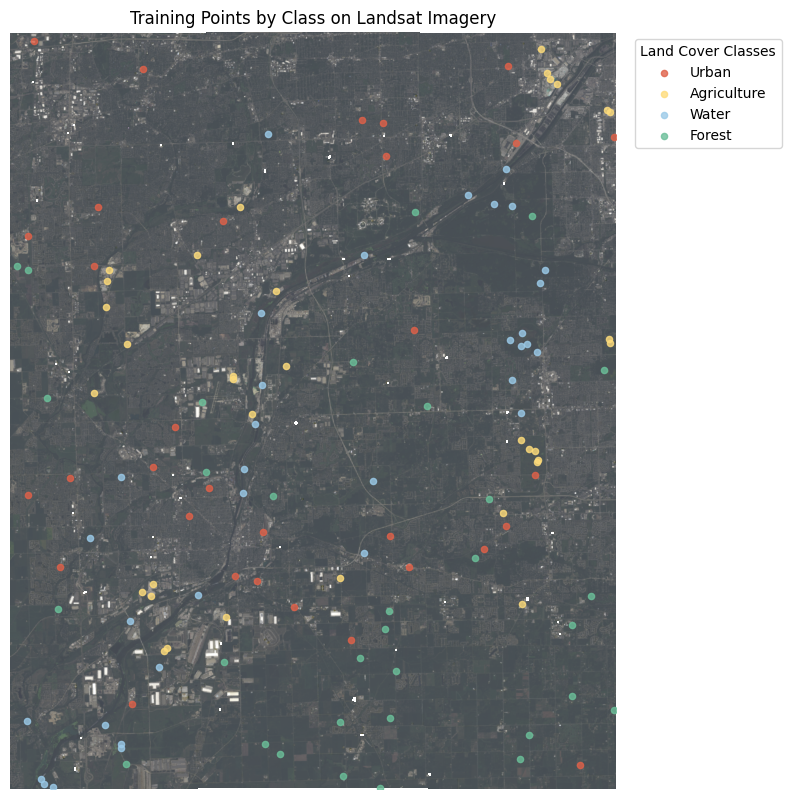

In [39]:
# Select bands for RGB visualization
#
rgb_bands = [3, 2, 1] # index start from 0 so needs to -1
rgb = image[rgb_bands]

# Normalize to 0-1 range (handles any bit-depth)
rgb = rgb.astype('float32')
for i in range(3):
    rgb[i] = (rgb[i] - np.nanmin(rgb[i])) / (np.nanmax(rgb[i]) - np.nanmin(rgb[i])) + 0.1
rgb = np.clip(rgb, 0, 1)  # Ensure valid range
rgb = np.transpose(rgb, (1, 2, 0))  # Convert to [height, width, bands]

# Plot
fig, ax = plt.subplots(figsize=(8, 10))

# Display RGB image
ax.imshow(rgb, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

# Define colors for each class
class_colors = {
    0: class4_palette[0],
    1: class4_palette[1],
    2: class4_palette[2],
    3: class4_palette[3]
}

class_category = {
    0: 'Urban',
    1: 'Agriculture',
    2: 'Water',
    3: 'Forest'
}

# Plot each class separately with its color
for class_val, color in class_colors.items():
    class_points = labels[labels['class'] == class_val]
    if not class_points.empty:
        class_points.plot(
            ax=ax,
            marker='o',
            color=color,
            markersize=20,
            alpha=0.8,
            edgecolor=color,
            linewidth=1,
            label=class_category[class_val]
        )

# Add legend
ax.legend(title='Land Cover Classes', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.axis('off')  # Hide axes

plt.title('Training Points by Class on Landsat Imagery')
plt.tight_layout()
plt.show()

## 3. Model Training and Evaluation

### 3.1 Model Training

Before we start training the model, we need to extract the pixel values that each training point is on and put those values in one geodataframe.

In [40]:
# Extract coordinates from GeoJSON
point_coords = [(geom.x, geom.y) for geom in labels.geometry]

# Extract pixel values for all bands
with rasterio.open(landsat_path) as src:
    pixel_values = list(src.sample(point_coords))  # Returns a generator
    pixel_values = np.array(pixel_values)  # Convert to array [n_points, n_bands]

# Add extracted values to GeoDataFrame
for band in range(pixel_values.shape[1]):
    labels[f'band_{band+1}'] = pixel_values[:, band]  # +1 for 1-based band numbering

labels.head()

id  class                          geometry    band_1    band_2    band_3  \
0  0_2      0  POINT (-9800464.382 5085048.158)  0.059160  0.080252  0.144080   
1  0_3      0  POINT (-9809179.429 5092575.858)  0.041230  0.048490  0.068208   
2  0_4      0   POINT (-9819830.587 5088352.63)  0.019230  0.030285  0.050223   
3  0_5      0  POINT (-9816676.896 5118138.619)  0.029872  0.033145  0.052752   
4  0_6      0      POINT (-9812978.3 5129584.5)  0.016508  0.019917  0.040405   

     band_4    band_5    band_6    band_7    band_8    band_9   band_10  \
0  0.143750  0.272120  0.297392  0.256115  0.308678  0.044376 -0.347275   
1  0.061443  0.261230  0.160333  0.097028  0.619165 -0.239342 -0.403102   
2  0.051323  0.272588  0.170260  0.095927  0.683106 -0.231067 -0.544431   
3  0.042907  0.301793  0.172405  0.088557  0.751044 -0.272856 -0.531417   
4  0.029350  0.321647  0.151423  0.071617  0.832762 -0.359830 -0.578736   

   band_11   band_12   band_13   band_14   band_15   band_16   band_17  \
0    195.0  0.495159 -0.107360  0.174845 -0.167118  0.108848  0.109270   
1    205.0  1.030274  0.005307  0.047987  0.009845  0.067193  0.070505   
2    187.0  1.531987 -0.104610 -0.050930  0.048015  0.074863  0.064966   
3    208.0  1.018769  0.011220  0.050435 -0.007920  0.054502  0.050566   
4    221.0  0.819919  0.032807 -0.011192  0.007370  0.056889  0.045127   

    band_18   band_19   band_20   band_21   band_22   band_23   band_24  \
0 -0.087890  0.154935 -0.146190  0.117443  0.114924  0.051617  0.137637   
1 -0.012815  0.068420  0.021450  0.064673  0.066900  0.276073 -0.003492   
2 -0.126693 -0.017188  0.060638  0.078422  0.068427  0.036658  0.109752   
3  0.018040  0.072215  0.006160  0.050372  0.043856 -0.026262 -0.223163   
4  0.043450  0.006600  0.012788  0.051251  0.036172 -0.043230 -0.130625   

    band_25   band_26   band_27   band_28   band_29   band_30   band_31  \
0 -0.057172  0.278805  0.266200 -0.001375  0.236995 -0.303683  0.226787   
1  0.065175  0.267904  0.271650  0.119818  0.081978  0.063745  0.170420   
2  0.064268  0.287224  0.287591 -0.065670  0.032340  0.073947  0.197945   
3  0.059648  0.283155  0.308645  0.048923 -0.026372  0.006957  0.174168   
4 -0.018838  0.279602  0.307254  0.073095 -0.044990  0.032972  0.170794   

    band_32  
0  0.231851  
1  0.173865  
2  0.191186  
3  0.172721  
4  0.163081

The column name is not helpful for understanding, so now we change the column name to the actual band names. We first generate a dictionary for name reference.

In [41]:
df_complete_stats_with_index = df_complete_stats.reset_index()
df_complete_stats_with_index['index'] = df_complete_stats_with_index['index'] + 1

band_name_mapping = dict(zip(
    df_complete_stats_with_index['index'],
    df_complete_stats_with_index['band_id']
))

print(band_name_mapping)

{1: 'SR_B1', 2: 'SR_B2', 3: 'SR_B3', 4: 'SR_B4', 5: 'SR_B5', 6: 'SR_B6', 7: 'SR_B7', 8: 'NDVI', 9: 'NDBI', 10: 'MNDWI', 11: 'elevation', 12: 'slope', 13: 'SR_B3_sobel_h', 14: 'SR_B3_sobel_v', 15: 'SR_B3_laplacian', 16: 'SR_B3_mean', 17: 'SR_B3_gauss', 18: 'SR_B4_sobel_h', 19: 'SR_B4_sobel_v', 20: 'SR_B4_laplacian', 21: 'SR_B4_mean', 22: 'SR_B4_gauss', 23: 'SR_B5_sobel_h', 24: 'SR_B5_sobel_v', 25: 'SR_B5_laplacian', 26: 'SR_B5_mean', 27: 'SR_B5_gauss', 28: 'SR_B6_sobel_h', 29: 'SR_B6_sobel_v', 30: 'SR_B6_laplacian', 31: 'SR_B6_mean', 32: 'SR_B6_gauss'}


Replace the band number with its real band name that represent what data it is about.

In [42]:
# Generate new column names
new_columns = []
for col in labels.columns:
    if col.startswith('band_'):
        band_id = int(col.split('_')[1])
        new_name = band_name_mapping.get(band_id, col)  # Fallback to original if not found
        new_columns.append(new_name)
    else:
        new_columns.append(col)  # Keep non-band columns unchanged

# Assign new column names
labels.columns = new_columns

labels.head()

id  class                          geometry     SR_B1     SR_B2     SR_B3  \
0  0_2      0  POINT (-9800464.382 5085048.158)  0.059160  0.080252  0.144080   
1  0_3      0  POINT (-9809179.429 5092575.858)  0.041230  0.048490  0.068208   
2  0_4      0   POINT (-9819830.587 5088352.63)  0.019230  0.030285  0.050223   
3  0_5      0  POINT (-9816676.896 5118138.619)  0.029872  0.033145  0.052752   
4  0_6      0      POINT (-9812978.3 5129584.5)  0.016508  0.019917  0.040405   

      SR_B4     SR_B5     SR_B6     SR_B7      NDVI      NDBI     MNDWI  \
0  0.143750  0.272120  0.297392  0.256115  0.308678  0.044376 -0.347275   
1  0.061443  0.261230  0.160333  0.097028  0.619165 -0.239342 -0.403102   
2  0.051323  0.272588  0.170260  0.095927  0.683106 -0.231067 -0.544431   
3  0.042907  0.301793  0.172405  0.088557  0.751044 -0.272856 -0.531417   
4  0.029350  0.321647  0.151423  0.071617  0.832762 -0.359830 -0.578736   

   elevation     slope  SR_B3_sobel_h  SR_B3_sobel_v  SR_B3_laplacian  \
0      195.0  0.495159      -0.107360       0.174845        -0.167118   
1      205.0  1.030274       0.005307       0.047987         0.009845   
2      187.0  1.531987      -0.104610      -0.050930         0.048015   
3      208.0  1.018769       0.011220       0.050435        -0.007920   
4      221.0  0.819919       0.032807      -0.011192         0.007370   

   SR_B3_mean  SR_B3_gauss  SR_B4_sobel_h  SR_B4_sobel_v  SR_B4_laplacian  \
0    0.108848     0.109270      -0.087890       0.154935        -0.146190   
1    0.067193     0.070505      -0.012815       0.068420         0.021450   
2    0.074863     0.064966      -0.126693      -0.017188         0.060638   
3    0.054502     0.050566       0.018040       0.072215         0.006160   
4    0.056889     0.045127       0.043450       0.006600         0.012788   

   SR_B4_mean  SR_B4_gauss  SR_B5_sobel_h  SR_B5_sobel_v  SR_B5_laplacian  \
0    0.117443     0.114924       0.051617       0.137637        -0.057172   
1    0.064673     0.066900       0.276073      -0.003492         0.065175   
2    0.078422     0.068427       0.036658       0.109752         0.064268   
3    0.050372     0.043856      -0.026262      -0.223163         0.059648   
4    0.051251     0.036172      -0.043230      -0.130625        -0.018838   

   SR_B5_mean  SR_B5_gauss  SR_B6_sobel_h  SR_B6_sobel_v  SR_B6_laplacian  \
0    0.278805     0.266200      -0.001375       0.236995        -0.303683   
1    0.267904     0.271650       0.119818       0.081978         0.063745   
2    0.287224     0.287591      -0.065670       0.032340         0.073947   
3    0.283155     0.308645       0.048923      -0.026372         0.006957   
4    0.279602     0.307254       0.073095      -0.044990         0.032972   

   SR_B6_mean  SR_B6_gauss  
0    0.226787     0.231851  
1    0.170420     0.173865  
2    0.197945     0.191186  
3    0.174168     0.172721  
4    0.170794     0.163081

Split the data into a training dataset (70%) and a validation dataset (30%).

In [43]:
# Define your feature set and target
features = labels.columns.tolist()[3:]
x = labels[features]
y = labels["class"]

# 70% training, 30% validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

Train a random forest model using the training set with all engineered features.

In [44]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

After training, analyze [variable importance scores](https://stackoverflow.com/questions/74519767/interpreting-variable-importance-from-random-forest-in-gee) to justify each feature's inclusion.

In [45]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. SR_B5_mean (0.0811)
2. SR_B6_mean (0.0617)
3. SR_B5_gauss (0.0610)
4. SR_B3_gauss (0.0569)
5. SR_B3_mean (0.0476)
6. SR_B6_gauss (0.0470)
7. SR_B7 (0.0467)
8. SR_B5 (0.0438)
9. NDVI (0.0381)
10. NDBI (0.0362)
11. SR_B4_mean (0.0361)
12. SR_B4_gauss (0.0347)
13. SR_B3 (0.0328)
14. MNDWI (0.0322)
15. slope (0.0315)
16. SR_B2 (0.0292)
17. SR_B1 (0.0272)
18. SR_B4 (0.0269)
19. SR_B6 (0.0264)
20. elevation (0.0249)
21. SR_B4_laplacian (0.0191)
22. SR_B3_laplacian (0.0190)
23. SR_B6_sobel_v (0.0189)
24. SR_B4_sobel_v (0.0157)
25. SR_B5_sobel_h (0.0157)
26. SR_B3_sobel_v (0.0156)
27. SR_B6_laplacian (0.0151)
28. SR_B5_sobel_v (0.0142)
29. SR_B6_sobel_h (0.0140)
30. SR_B4_sobel_h (0.0112)
31. SR_B5_laplacian (0.0103)
32. SR_B3_sobel_h (0.0093)


 This model is rerun for serveral times to test for the features that can produce the highest accuracy. In the end, the final model use `SR_B5_mean`, `SR_B6_mean`, `SR_B5_gauss`, `SR_B3_gauss`, `SR_B3_mean`, and `SR_B6_gauss`, with `SR_B5_mean` being the most influential feature.

In [46]:
features = ['SR_B5_mean', 'SR_B6_mean', 'SR_B5_gauss', 'SR_B3_gauss', 'SR_B3_mean', 'SR_B6_gauss']
x = labels[features]
y = labels["class"]

# 70% training, 30% validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(x_train, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. SR_B3_mean (0.1871)
2. SR_B5_mean (0.1858)
3. SR_B6_mean (0.1853)
4. SR_B5_gauss (0.1568)
5. SR_B3_gauss (0.1515)
6. SR_B6_gauss (0.1335)


The model averaged **68.86%** accuracy

Accuracy typically varied by **±11.93%** between folds

For the land cover classification, cross validation gives a more trustworthy accuracy estimate than the initial 70/30 split, especially if some classes (e.g., agriculture vs. urban) are easily confused. The ± value helps assess if the model performs consistently across different areas of the study region.

In [47]:
# Apply 5-fold cross-validation
cv_scores = cross_val_score(model, x, y, cv=5, scoring='accuracy')

# Compute mean and standard deviation of accuracy
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

Cross-Validation Accuracy: 0.6886 ± 0.1193


### 3.2 Accuracy Assessment

Use the trained model to classify the Landsat 8 image, creating a land cover classification map with classes for urban, agriculture, water, and vegetation.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


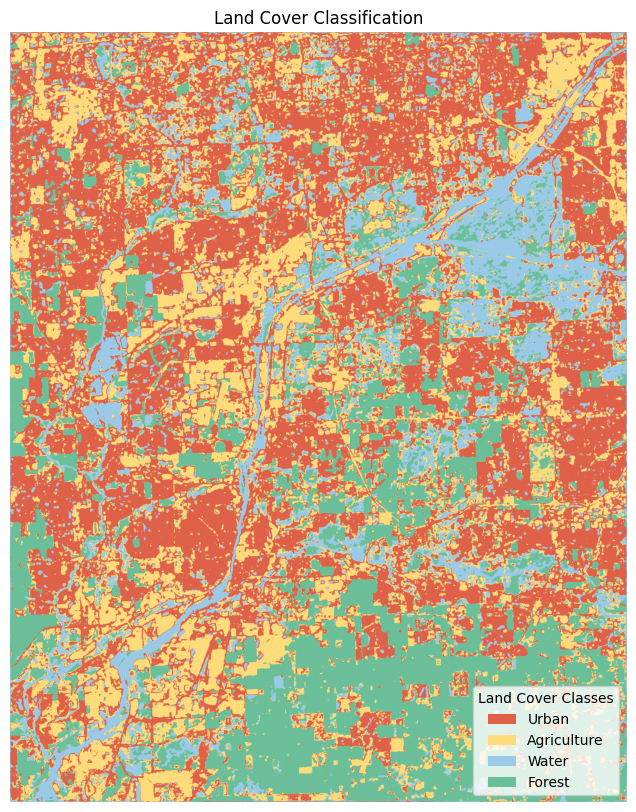

In [49]:
# Define classification function
def classify_landsat_image(image_path, model, features, class_category):
    """
    Classify a Landsat image using a trained RandomForest model

    Args:
        image_path: Path to Landsat GeoTIFF file
        model: Trained RandomForest classifier
        features: List of features used in training (band names)
        class_category: Dictionary mapping class numbers to names

    Returns:
        classified_image: 2D numpy array with class predictions
        metadata: Original image metadata (for saving output)
    """

    # Open the GeoTIFF file
    with rasterio.open(image_path) as src:
        # Read all bands
        image = src.read()
        metadata = src.meta.copy()

        # Get band names from the image
        band_names = src.descriptions

        # Reshape the image for classification (from [bands, height, width] to [height*width, bands])
        height, width = image.shape[1], image.shape[2]
        image_reshaped = image.transpose(1, 2, 0).reshape(-1, image.shape[0])

        # Create a dictionary mapping band names to their indices
        band_dict = {name: idx for idx, name in enumerate(band_names)}

        # Extract only the bands used in training (in the correct order)
        feature_indices = [band_dict[feature] for feature in features]
        image_features = image_reshaped[:, feature_indices]

        # Classify the image
        predictions = model.predict(image_features)

        # Reshape predictions back to 2D
        classified_image = predictions.reshape(height, width)

        return classified_image, metadata

# Classify the image
classified_map, metadata = classify_landsat_image(
    landsat_path,
    model,
    features,
    class_category=class_category
)

# Update metadata for the classified image (single band, uint8)
metadata.update({
    'count': 1,
    'dtype': 'uint8',
    'nodata': None
})

# Visualize the results
plt.figure(figsize=(8, 10))

# Create a colormap for your classes
cmap = plt.cm.colors.ListedColormap(class4_palette)

# Plot the classified image
plt.imshow(classified_map, cmap=cmap)

# Create a legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, edgecolor=None, label=class_category[i])
                   for i, color in enumerate(class4_palette)]
plt.legend(handles=legend_elements, title='Land Cover Classes', loc='lower right')

plt.title('Land Cover Classification')
plt.axis('off')
plt.show()

In [76]:
# Save the classified map
output_path = '/content/drive/MyDrive/GEE_Exports/landcover_classification.tif'
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(classified_map.astype('uint8'), 1)

print("Classification completed and saved to:", output_path)

Classification completed and saved to: /content/drive/MyDrive/GEE_Exports/landcover_classification.tif


Using the validation data, generate a confusion matrix and calculate the overall accuracy, precision, and recall. The urban and agriculture confused the most with each other. The reason may be that bare soil in agricultural fields can resemble urban areas and the urban pattern is usually conplex and can not be easily represented by single pixel value. The forest is also confused with agriculture becuase these can both be vegetation and have similar reflection pattern.

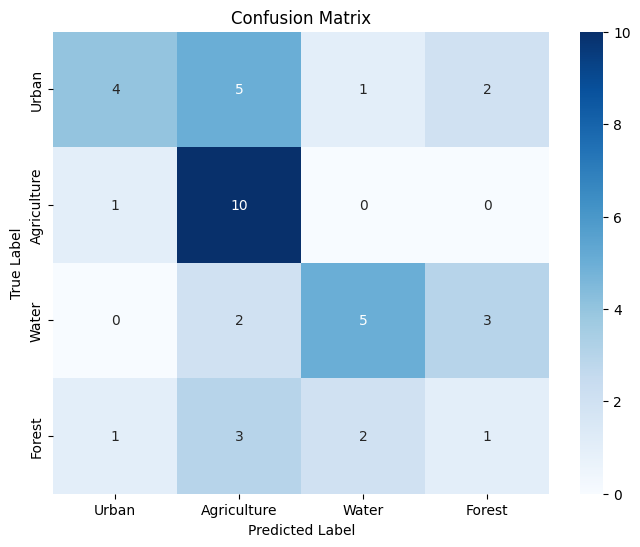

In [50]:
# Predict on validation data
y_pred = model.predict(x_val)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
class_names = list(class_category.values())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [51]:
# Core metrics
overall_accuracy = accuracy_score(y_val, y_pred)
kappa = cohen_kappa_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=class_category.values(), output_dict=True)

# 3. Create comprehensive metrics DataFrame
metrics_data = {
    'Metric': ['Overall Accuracy', "Cohen's Kappa"],
    'Value': [overall_accuracy, kappa]
}

# Add per-class metrics
for i, class_name in enumerate(class_category.values()):
    metrics_data['Metric'].extend([
        f'{class_name} Precision',
        f'{class_name} Recall',
        f'{class_name} F1-Score'
    ])
    metrics_data['Value'].extend([
        report[class_name]['precision'],
        report[class_name]['recall'],
        report[class_name]['f1-score']
    ])

metrics_df = pd.DataFrame(metrics_data)

# 4. Create confusion matrix DataFrames
cm_df = pd.DataFrame(cm,
                    index=[f"True {name}" for name in class_category.values()],
                    columns=[f"Pred {name}" for name in class_category.values()])

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(cm_percent.round(1),
                           index=cm_df.index,
                           columns=cm_df.columns)

# 5. Export to Excel with multiple sheets
output_metrics_path = '/content/drive/MyDrive/GEE_Exports/accuracy_metrics.xlsx'
with pd.ExcelWriter(output_metrics_path) as writer:
    metrics_df.to_excel(writer, sheet_name='Accuracy Metrics', index=False)
    cm_df.to_excel(writer, sheet_name='Confusion Matrix (Counts)')
    cm_percent_df.to_excel(writer, sheet_name='Confusion Matrix (%)')

    # Add full classification report
    pd.DataFrame(report).transpose().to_excel(writer, sheet_name='Detailed Report')

# 6. Print summary to console
print("\n" + "="*50)
print("Classification Accuracy Report")
print("="*50)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}\n")

print("Per-Class Metrics:")
print(pd.DataFrame(report).transpose()[['precision', 'recall', 'f1-score']].round(4))

print("\nConfusion Matrix (Counts):")
print(cm_df)

print("\nConfusion Matrix (% of True Class):")
print(cm_percent_df)


Classification Accuracy Report

Overall Accuracy: 0.5000
Cohen's Kappa: 0.3255

Per-Class Metrics:
              precision  recall  f1-score
Urban            0.6667  0.3333    0.4444
Agriculture      0.5000  0.9091    0.6452
Water            0.6250  0.5000    0.5556
Forest           0.1667  0.1429    0.1538
accuracy         0.5000  0.5000    0.5000
macro avg        0.4896  0.4713    0.4498
weighted avg     0.5229  0.5000    0.4766

Confusion Matrix (Counts):
                  Pred Urban  Pred Agriculture  Pred Water  Pred Forest
True Urban                 4                 5           1            2
True Agriculture           1                10           0            0
True Water                 0                 2           5            3
True Forest                1                 3           2            1

Confusion Matrix (% of True Class):
                  Pred Urban  Pred Agriculture  Pred Water  Pred Forest
True Urban              33.3              41.7         8.3         


Visually compare the landcover data for the ROI with the corresponding [landcover data from the European Space Agency](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200).

In [52]:
# Function to load and prepare ESA WorldCover data
def get_esa_worldcover(roi, year=2021):
    esa = ee.ImageCollection("ESA/WorldCover/v200").first()
    return esa.clip(roi)

# Get ESA data
esa_lc = get_esa_worldcover(chicago_region)

Export the ESA classification as well to matin the same dtype for plots.

In [83]:
# Export image for labeling processing

esa_lc = esa_lc.toFloat()

export_task = ee.batch.Export.image.toDrive(
    image=esa_lc,
    description="ESA_ref",
    folder="GEE_Exports",
    fileNamePrefix="ESA_ref",
    scale=30,
    region=chicago_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'ESA_ref', 'priority': 100, 'creation_timestamp_ms': 1745021235631, 'update_timestamp_ms': 1745021235631, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'BWAIFERSP5J6K2GU7PSIYFBP', 'name': 'projects/ee-musa-remote-sensing/operations/BWAIFERSP5J6K2GU7PSIYFBP'}


In [89]:
export_task.status()

{'state': 'COMPLETED',
 'description': 'ESA_ref',
 'priority': 100,
 'creation_timestamp_ms': 1745021235631,
 'update_timestamp_ms': 1745021317358,
 'start_timestamp_ms': 1745021239667,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/16ypKnn_a5G9Ig5OP9Tga0VOX8z4eHY8J'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 4.983816146850586,
 'id': 'BWAIFERSP5J6K2GU7PSIYFBP',
 'name': 'projects/ee-musa-remote-sensing/operations/BWAIFERSP5J6K2GU7PSIYFBP'}

Plot the prediction and ESA classification side by side. For better comparision, the ESA classification is colored in the same way as our prediction, which use 4 colors to stand for 4 types of landcover.

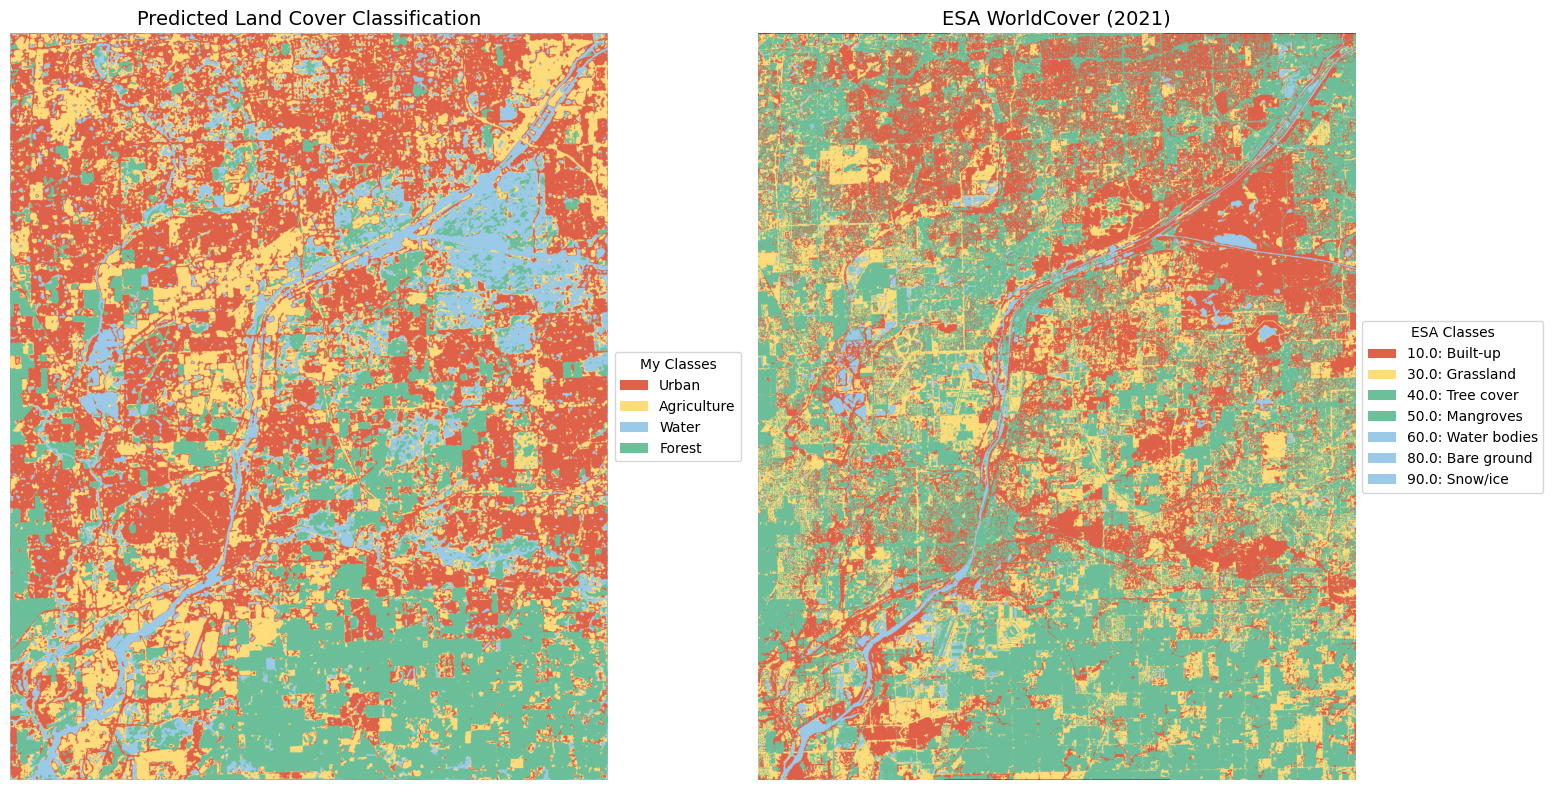

In [55]:
# Load ESA WorldCover image
esa_lc_path = '/content/drive/MyDrive/GEE_Exports/ESA_ref.tif'
with rasterio.open(esa_lc_path) as src:
    esa_lc = src.read(1)
    esa_transform = src.transform
    esa_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# ESA WorldCover categories to 4 colors
esa_palette = {
    10: [0.875, 0.380, 0.286],  # Built-up
    20: [0.996, 0.863, 0.482],      # Cropland
    30: [0.996, 0.863, 0.482],       # Grassland
    40: [0.420, 0.749, 0.600],       # Tree cover
    50: [0.420, 0.749, 0.600],       # Mangroves
    60: [0.608, 0.792, 0.910],     # Water
    70: [0.608, 0.792, 0.910],   # Moss and lichen
    80: [0.608, 0.792, 0.910],   # Bare ground
    90: [0.608, 0.792, 0.910],   # Snow and ice
    95: [0.608, 0.792, 0.910],   # Permanent water bodies
    100: [0, 0, 0]         # No data
}

# function for ESA class names
def get_esa_class_name(class_id):
    esa_names = {
        10: "Built-up",
        20: "Cropland",
        30: "Grassland",
        40: "Tree cover",
        50: "Mangroves",
        60: "Water bodies",
        70: "Moss/lichens",
        80: "Bare ground",
        90: "Snow/ice",
        95: "Permanent water",
        100: "No data"
    }
    return esa_names.get(class_id, f"Class {class_id}")

# Create figure
plt.figure(figsize=(16, 8))

# Plot classification (left)
plt.subplot(1, 2, 1)
plt.imshow(classified_map, cmap=plt.cm.colors.ListedColormap(class4_palette),
           extent=esa_extent, vmin=0, vmax=3)
plt.title('Predicted Land Cover Classification', fontsize=14)

# Create legend for your classes
my_legend = [Patch(facecolor=color, edgecolor=None, label=class_category[i])
              for i, color in enumerate(class4_palette)]
plt.legend(handles=my_legend, title='My Classes', bbox_to_anchor=(1, 0.5), loc='center left')
plt.axis('off')

# Plot ESA classification (right)
plt.subplot(1, 2, 2)
# Create RGB array for ESA data
esa_rgb = np.zeros((esa_lc.shape[0], esa_lc.shape[1], 3))
for value, color in esa_palette.items():
    esa_rgb[esa_lc == value] = color

plt.imshow(esa_rgb, extent=esa_extent)
plt.title('ESA WorldCover (2021)', fontsize=14)

# Create simplified ESA legend (only classes present in area)
unique_esa = np.unique(esa_lc)
esa_legend = [Patch(facecolor=esa_palette[cls],
                   label=f"{cls}: {get_esa_class_name(cls)}")
             for cls in unique_esa if cls in esa_palette]
plt.legend(handles=esa_legend, title='ESA Classes', bbox_to_anchor=(1, 0.5), loc='center left')
plt.axis('off')

plt.tight_layout()
plt.show()

The classifications do not match well. The water category is missed the most, which may be because the shoreline of the river has high sediment concentration and is muddy. This may make it similar to the urban condition, where paving materials have very similar material components. Besides, the ESA classification has way more forest area than our prediction. This may be because the suburb usually has a mixture of houses in the forest/on the lawn, which is hard to tell which is which.

However, there are also reasons that are not related to our model. Firstly, the ESA classification is in 10m resolution, which is much more refined than our 30m Landsat data. In this way, our model cannot generate such details as shown in the ESA image.

Therefore, we also want to compare our result with the reclassified NLCD dataset for a clearer comparision.

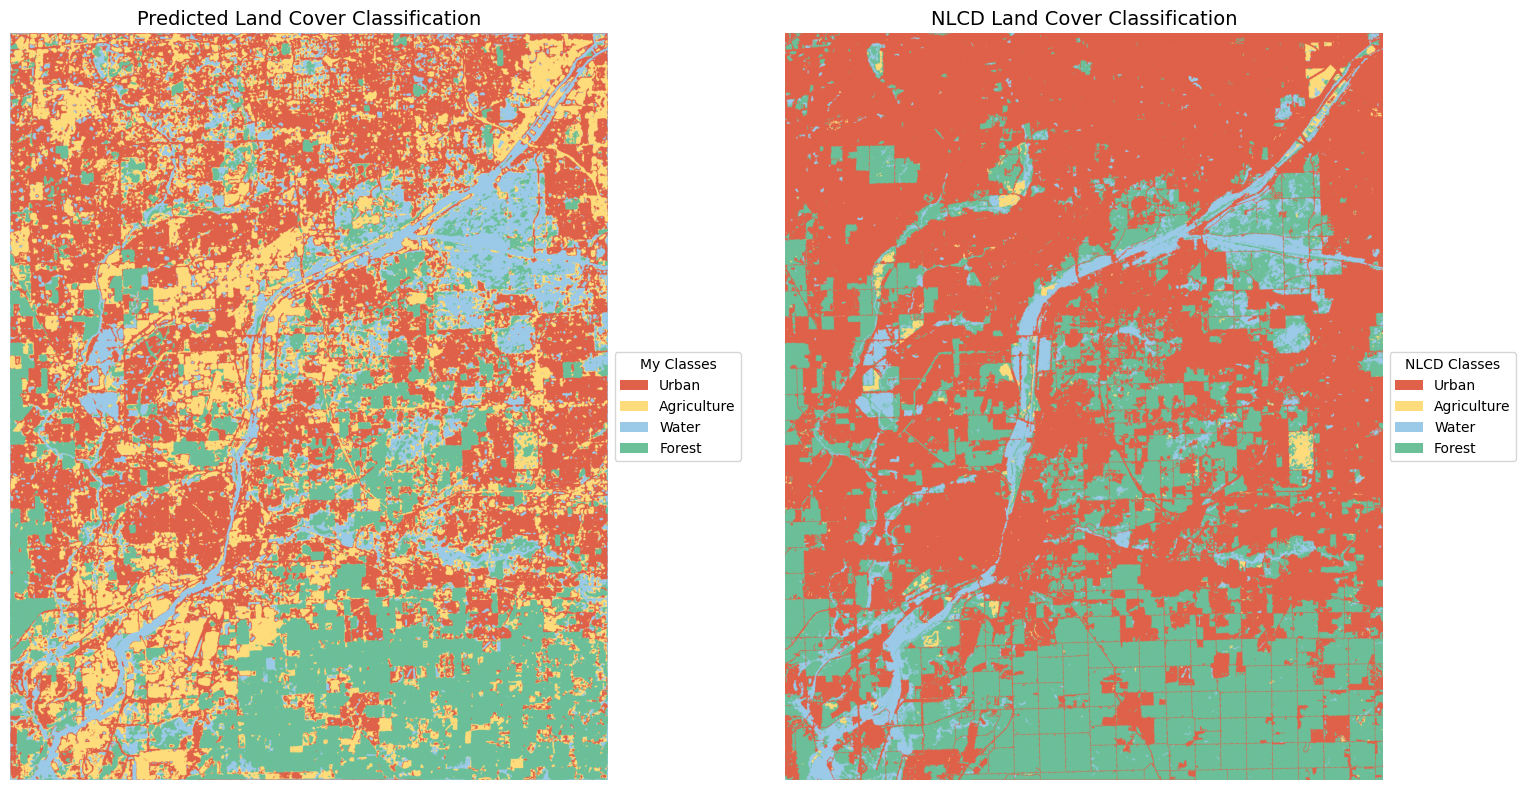

In [54]:
# Load NLCD Reclass image
nlcd_lc_path = '/content/drive/MyDrive/GEE_Exports/nlcd_Reclass.tif'
with rasterio.open(nlcd_lc_path) as src:
    nlcd_lc = src.read(1)
    nlcd_transform = src.transform
    nlcd_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Create figure
plt.figure(figsize=(16, 8))

# Plot your classification (left)
plt.subplot(1, 2, 1)
plt.imshow(classified_map, cmap=plt.cm.colors.ListedColormap(class4_palette),
           extent=nlcd_extent, vmin=0, vmax=3)
plt.title('Predicted Land Cover Classification', fontsize=14)

# Create legend for your classes
plt.legend(handles=my_legend, title='My Classes', bbox_to_anchor=(1, 0.5), loc='center left')
plt.axis('off')

# Plot nlcd classification (left)
plt.subplot(1, 2, 2)
plt.imshow(nlcd_lc, cmap=plt.cm.colors.ListedColormap(class4_palette),
           extent=nlcd_extent, vmin=0, vmax=3)
plt.title('NLCD Land Cover Classification', fontsize=14)

# Create legend for your classes
plt.legend(handles=my_legend, title='NLCD Classes', bbox_to_anchor=(1, 0.5), loc='center left')
plt.axis('off')

plt.tight_layout()
plt.show()

For this comparision, there are much more agriculture land in our prediction than in the NLCD dataset. The model struggles to distinguish between the agriculture and urban the most.

## 4. Reflection Questions


***What limitations did you run into when completing this assignment? What might you do differently if you repeated it, or what might you change if you had more time and/or resources?***

One limitation is the training sample format. It is hard to distinguish the categories at the pixel level. I can distinguish the patches, but when zooming into each pixel, the pixel may be very different, even if they are all `urban`. For example, the white roofs look very different from the highway. The black shadows also make it harder, especially for our 30m resolution. Therefore, an object-based classification may be more suitable than a pixel-based classification.

Besides, the training samples are not enough. It will be better if I input more samples for the model to learn from.

***What was the impact of feature engineering? Which layers most contributed to the model? Did you expect this? Why or why not?***

The `SR_B3_mean` most contributed to the model, the smoothed mean reflectance of the Green band (Band 3), indicating that vegetation-related information was key for predictions. This was expected because the Green band is sensitive to healthy vegetation, and our ROI is in a suburb area with rich vegetation coverage. The smoothing likely helped reduce noise while preserving important spatial trends. Overall, the results align with spectral behavior in remote sensing.

***Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? If so, how might you resolve this in the future (hint: consider a different sampling technique).***

I have always used hand labeling in my previous remote sensing projects in ArcGIS Pro, so this time I want to learn and try other ways of labeling. Especially because I know it is hard to label our categories on a pixel level. I use nlcd dataset to automate the labeling process; the time I spend figuring it out is no less than hand labeling, but this new approach can be easier to generalize and used in other areas.

Besides, I also noticed that the 4 categories I used are very imbalanced. There is much less agricultural land than other categories. I originally had many more points from other categories than agriculture, which generated very bad results because the model cannot learn from the agriculture category. In this way, in the final model, I try to keep the points in each category the same. Also, as mention above, an object-based model will be better.

***Did your model perform better on one class than another? Why? Can you think of a reason that this might be good or bad depending on the context?***

The precison of urban, agriculture, and water is similar, but my model performs very bad on forest. I think this is because of the condition of suburb area, which have high vegetation covergae but also has development mixed in between. This misclassification could be problematic in conservation or carbon sequestration studies where accurate forest detection is critical. Conversely, if the focus is urban expansion, lower forest precision might be less concerning.